In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from pandas import Series

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

from sklearn.model_selection import GridSearchCV


from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics


In [2]:
RANDOM_SEED = 42

# Загрузка и подготовка данных


In [3]:
data_tr =  pd.read_csv('train.csv')
data_te = pd.read_csv('test.csv')

In [4]:
# беглая оценка данных для понимания типа данных и их уникальности
pd.concat([data_tr, data_te], sort=False).agg({'nunique',lambda x:x.unique()}).transpose()

,nunique,<lambda>
client_id,110148,"[25905, 63161, 25887, 16222, 101655, 41415, 28..."
app_date,120,"[01FEB2014, 12MAR2014, 23JAN2014, 18APR2014, 1..."
education,5,"[SCH, GRD, UGR, PGR, ACD, nan]"
sex,2,"[M, F]"
age,52,"[62, 59, 25, 53, 48, 27, 39, 50, 54, 29, 32, 3..."
car,2,"[Y, N]"
car_type,2,"[Y, N]"
decline_app_cnt,24,"[0, 2, 1, 3, 4, 6, 5, 7, 8, 9, 13, 11, 19, 10,..."
good_work,2,"[0, 1]"
score_bki,102618,"[-2.00875292, -1.53227621, -1.40814226, -2.057..."


In [5]:
# формируем массивы колонок различных типов для упрощения дальнейшей работы с ними
# при появлении новых признаков массивы колонок будут дополняться
bin_cols=['sex','car','car_type','good_work','foreign_passport']
cat_cols=['education','home_address','work_address', 'sna', 'first_time','region_rating']
num_cols=['age','decline_app_cnt','bki_request_cnt','income','score_bki']

## Вспомогательные функции для обработки данных

In [6]:
# поиск выбросов по имени колонки
def clear_outliers(col_name, data_input):
    data_output = data_input.copy()
    q13 = data_output[col_name].quantile([0.25,0.75])
    razm=q13[0.75]-q13[0.25]
    q1=q13[0.25]-1.5*razm
    q3=q13[0.75]+1.5*razm
    data_output=data_output[(data_output[col_name]>=q1) & (data_output[col_name]<=q3)]
    return data_output

# отображение roc-кривой
def dispaly_roc_curve(y_valid, probs):
    fpr, tpr, threshold = metrics.roc_curve(y_valid, probs)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Logistic Regression. Roc_Auc.')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# confusion_matrix
def display_confusion_matrix(y_valid, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()
    names = ['TP','FP','FN','TN']
    counts = tp,fp,fn,tn
    labels = [f"{i} = {j}" for i, j in zip(names,counts)]
    akws = {"ha": 'center',"va": 'center',"size": 15, "color": "black"}
    plt.figure(figsize=(5,5))
    sns.heatmap(np.array(counts).reshape(2,2), annot=np.array(labels).reshape(2,2),
                annot_kws=akws, fmt='', center=10, cbar = False,
                xticklabels = ['Деф.','Не деф.'], yticklabels= ['Деф.','Не деф.'])
    plt.title('Confusion-matrix')
    plt.show()
    print(labels)
    print("Pos: {} from {} ({})".format(tp, tp+fn, tp/(tp+fn)))
    print("Neg: {} from {} ({})".format(tn, tn+fp, tn/(tn+fp)))
    
    
def display_metrics(y_valid, y_pred):
    print('accuracy = {}'.format(accuracy_score(y_valid, y_pred)))
    print('precision = {}'.format(precision_score(y_valid, y_pred)))
    print('recall = {}'.format(recall_score(y_valid, y_pred)))
    print('F1-score = {}'.format(f1_score(y_valid, y_pred)))

## Удаление выбросов
Для начала удалим выбросы на тренировочной выборке. 
Тестовую выборку в случае выбросов не трогаем, так как фин проверка в kaggle завязана на точное значение кол-ва элементов в тестовой выборке

In [7]:
# Отделим числовые значения. И проверим их на выбросы по принцпу, что попадает между 1 квартилью - 1.5 межквартильного размаха и 3-ей квартилью + 1.5 межквартильного размаха
for item in num_cols:
    data_tr=clear_outliers(item, data_tr)

## Объединение выборок
Для дальнейшей обработки объединяем тестовую и тренировочную выборку. Чтобы далее отличать эти выборки, присвоим каждой выборке отдельный признак.

In [8]:
# Добавляем  признак, который будет отличать тестовые данные от тренировочных и объединяем выборку для дальнейшей обработки
data_tr['is_test'] = 0
data_te['is_test'] = 1

data = pd.concat([data_tr, data_te], sort=False)

## Обработка пропусков

In [9]:
# Оценка и обработка пропусков
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92367 entries, 0 to 36348
Data columns (total 20 columns):
client_id           92367 non-null int64
app_date            92367 non-null object
education           91942 non-null object
sex                 92367 non-null object
age                 92367 non-null int64
car                 92367 non-null object
car_type            92367 non-null object
decline_app_cnt     92367 non-null int64
good_work           92367 non-null int64
score_bki           92367 non-null float64
bki_request_cnt     92367 non-null int64
region_rating       92367 non-null int64
home_address        92367 non-null int64
work_address        92367 non-null int64
income              92367 non-null int64
sna                 92367 non-null int64
first_time          92367 non-null int64
foreign_passport    92367 non-null object
default             56018 non-null float64
is_test             92367 non-null int64
dtypes: float64(2), int64(12), object(6)
memory usage: 14.8+ 

Исходя из данных выше пропуски есть в столбцах education и default. Обработаем их.

SCH    49723
GRD    28410
UGR    12195
PGR     1397
ACD      217
Name: education, dtype: int64

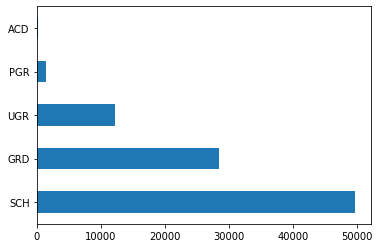

In [10]:
# Оцениваем соотношение значений в столбце education
data.education.value_counts().plot.barh()
data.education.value_counts()

In [11]:
# Заполняем пропуски в том соотношении, в котором существующие значения встречаются в данных
esum=data.education.value_counts().sum()
r_acd=int(100*data.education.value_counts().ACD/esum)
r_pgr=int(100*data.education.value_counts().PGR/esum)
r_ugr=int(100*data.education.value_counts().UGR/esum)
r_grd=int(100*data.education.value_counts().GRD/esum)
r_acd, r_pgr, r_ugr, r_grd

(0, 1, 13, 30)

In [12]:
# ACD не используем, так как соотношение этих записей к общему числу записей близко к нулю
data.education=data.education.fillna('PGR',limit=r_pgr)
data.education=data.education.fillna('UGR',limit=r_ugr)
data.education=data.education.fillna('GRD',limit=r_grd)
data.education=data.education.fillna('SCH')

In [13]:
# проверяем обновленные данные
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92367 entries, 0 to 36348
Data columns (total 20 columns):
client_id           92367 non-null int64
app_date            92367 non-null object
education           92367 non-null object
sex                 92367 non-null object
age                 92367 non-null int64
car                 92367 non-null object
car_type            92367 non-null object
decline_app_cnt     92367 non-null int64
good_work           92367 non-null int64
score_bki           92367 non-null float64
bki_request_cnt     92367 non-null int64
region_rating       92367 non-null int64
home_address        92367 non-null int64
work_address        92367 non-null int64
income              92367 non-null int64
sna                 92367 non-null int64
first_time          92367 non-null int64
foreign_passport    92367 non-null object
default             56018 non-null float64
is_test             92367 non-null int64
dtypes: float64(2), int64(12), object(6)
memory usage: 14.8+ 

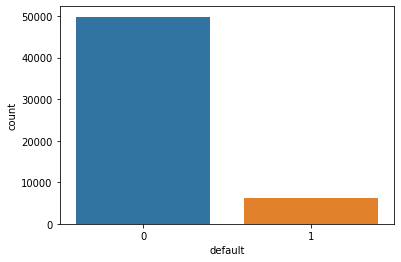

In [14]:
# В тестовых данных нет поля default и в силу этого данное поле имеет пропуски в объедененной выборке. 
# Заполним данное поле наиболее частым из значений. 
# Для этого оценим распределение значения в тренировочных данных
sns.countplot(data_tr['default'])

In [15]:
# заполним тестовые данные нулями
data.default=data.default.fillna(0)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92367 entries, 0 to 36348
Data columns (total 20 columns):
client_id           92367 non-null int64
app_date            92367 non-null object
education           92367 non-null object
sex                 92367 non-null object
age                 92367 non-null int64
car                 92367 non-null object
car_type            92367 non-null object
decline_app_cnt     92367 non-null int64
good_work           92367 non-null int64
score_bki           92367 non-null float64
bki_request_cnt     92367 non-null int64
region_rating       92367 non-null int64
home_address        92367 non-null int64
work_address        92367 non-null int64
income              92367 non-null int64
sna                 92367 non-null int64
first_time          92367 non-null int64
foreign_passport    92367 non-null object
default             92367 non-null float64
is_test             92367 non-null int64
dtypes: float64(2), int64(12), object(6)
memory usage: 14.8+ 

## Добавление новых признаков
На основе поля дата добавим в модель следующие признаки: <br>
1) Месяц<br>
2) Год<br>
3) Квартал<br>
4) День недели<br>
<br>
После добавления данных признаков проведем проверку на корреляцию признаков между собой

In [17]:
def convertStrToDate(date_str):
    patern = '%d%b%Y'
    return datetime.datetime.strptime(date_str,patern)

def getMonth(date_str):
    return convertStrToDate(date_str).month

def getYear(date_str):
    return convertStrToDate(date_str).year

def getQuarter(date_str):
    return getMonth(date_str)//4+1

def getDayOfWeek(date_str):
    return convertStrToDate(date_str).weekday()+1

In [18]:
data['app_month']=data.app_date.apply(getMonth)
data['app_year']=data.app_date.apply(getYear)
data['app_quarter']=data.app_date.apply(getQuarter)
data['app_weekday']=data.app_date.apply(getDayOfWeek)

In [19]:
# добавим получившиеся признаки в категориальный столбец
cat_cols=['education','home_address','work_address', 'sna', 'first_time', 'app_month', 'app_year', 'app_quarter','app_weekday']

## Проверка корреляции

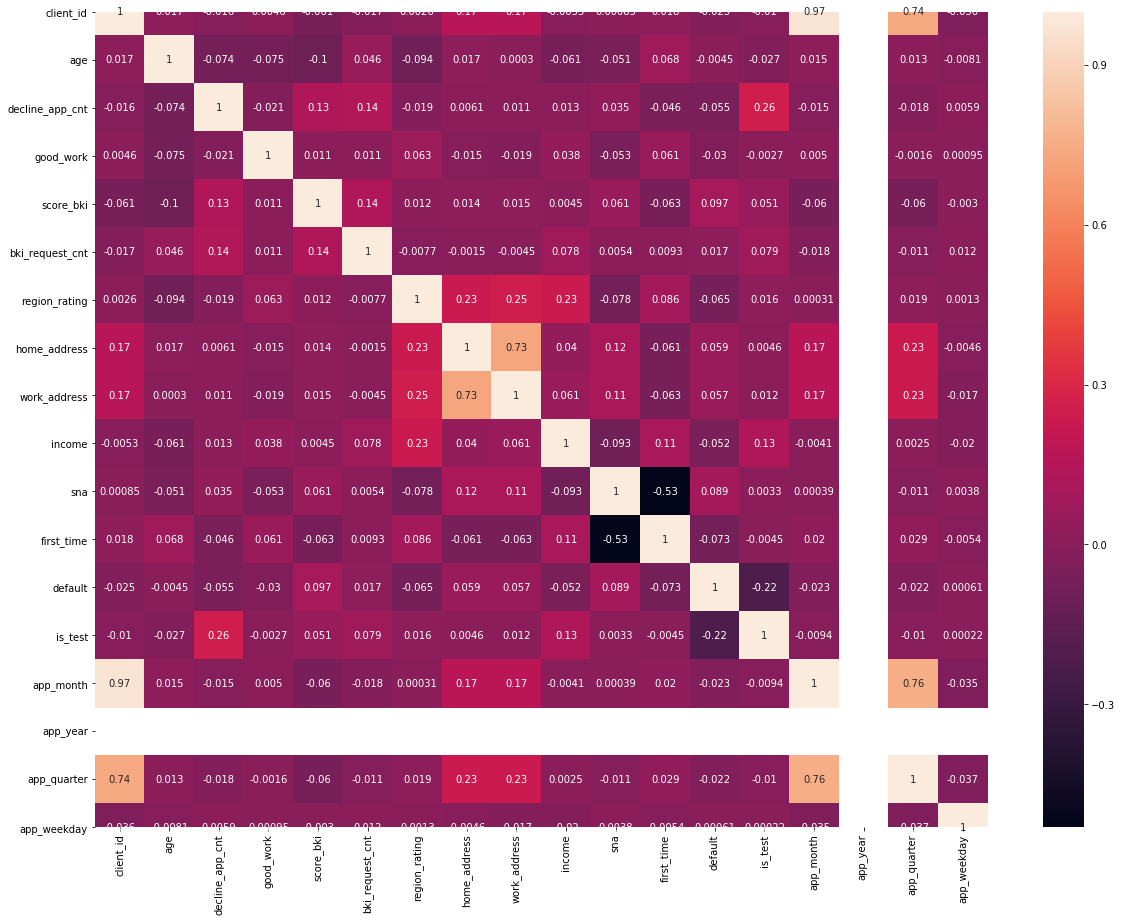

In [20]:
plt.figure(figsize = (20,15))
sns.heatmap(data.corr(), annot=True)

Исходя из информации выше можно убрать из данных поле год. 
Также высокая корреляция между полями квартала и месяца. B полями рабочий и домашний адреса. При этом так как корреляция не превышает 0.9, то эти поля можно оставить. 

In [21]:
# обновленная информация по категориальным столбцам, которые берем в обучение модели
cat_cols=['education','home_address','work_address', 'sna', 'first_time', 'app_month', 'app_quarter','app_weekday']

## Оценка числовых переменных

Построим графики распределения числовых переменных для оценки разброса данных. 

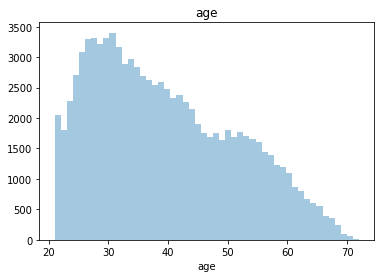

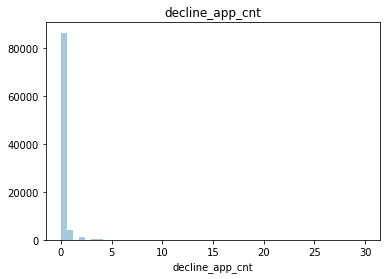

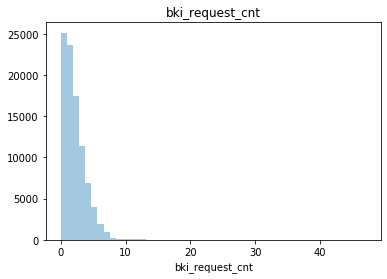

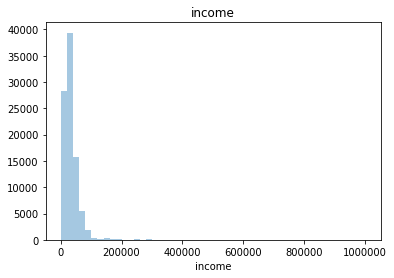

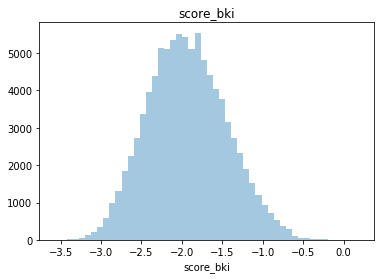

In [22]:
for column in num_cols:
    plt.figure()
    sns.distplot(data[column], kde = False, rug=False)
    plt.title(column)
    plt.show()

score_bki - распределен приблизительно нормально<br>
age,decline_app_cnt,bki_request_cnt,income - имеют неравномерное распределение с тяжелыми правыми хвостами. 
Построим прологарифмированные графики, чтобы понять, изменится ли ситуация. 

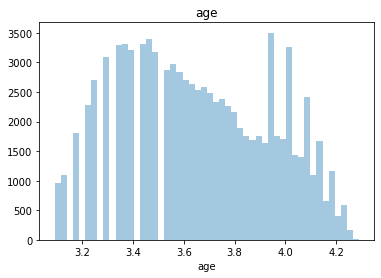

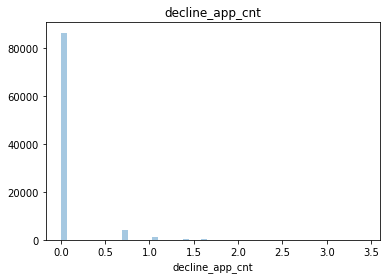

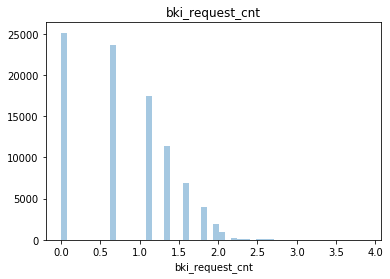

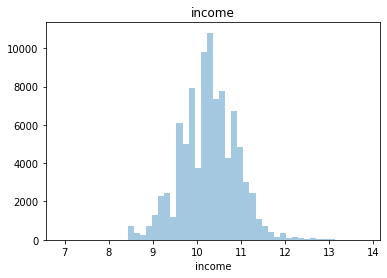

In [23]:
for column in num_cols[:-1]:
    plt.figure()
    sns.distplot(np.log(data[column]+1), kde = False, rug=False)
    plt.title(column)
    plt.show()

Как видно из графиков логарифмирование положительно влияет на распределение переменных. Применим его к нашим числовым данным. 

In [24]:
for column in num_cols[:-1]:
    data[column] = np.log(data[column] + 1)

## Оценка значимости числовых переменных

Оценку значимости будет выполнять на тренировочных данных (is_test = 0)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [1] are constant.
  UserWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


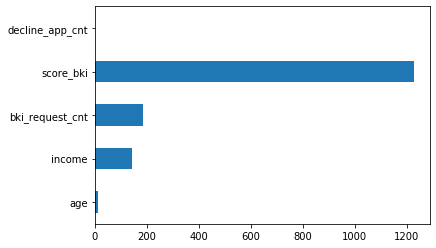

In [25]:
imp_num = Series(f_classif(data[data['is_test'] == 0][num_cols], data[data['is_test'] == 0]['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Из данных выше можно сделать вывод, что score_bki является самой значимой из числовых характеристик, а age самой незначительной

## Оценка бинарных переменных

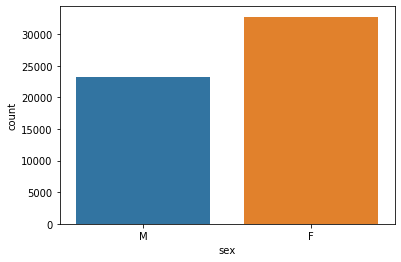

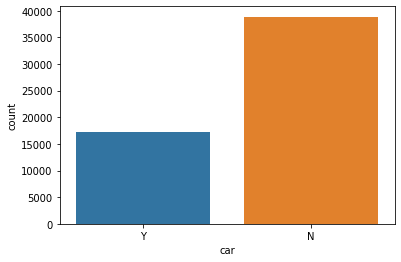

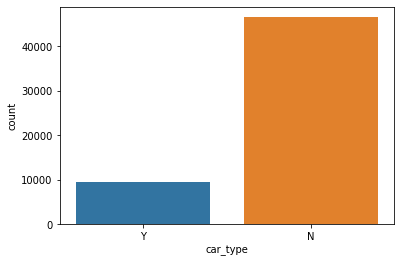

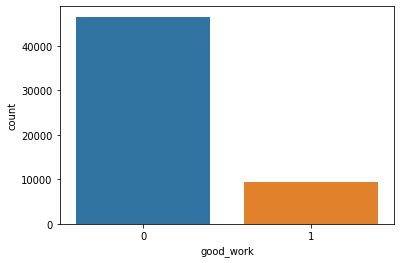

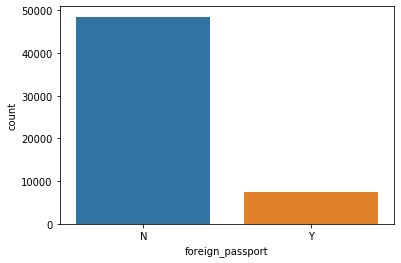

In [26]:
for i, col in enumerate(bin_cols):
    plt.figure(i)
    sns.countplot(x=col, data=data[data.is_test==0])


Исходя из графиков выше видимых проблем с данными нет. Далее произведем оценку значимости бинарных переменных.

## Оценка значимости бинарных переменных

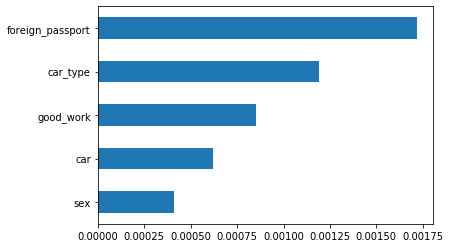

In [27]:
# Для оценки значимости с помощью LabelEncoder преобразуем бинарные переменные
label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
    

imp_bin = Series(mutual_info_classif(data[data['is_test'] == 0][bin_cols], data[data['is_test'] == 0]['default'],
                                     discrete_features =True), index = bin_cols)
imp_bin.sort_values(inplace = True)
imp_bin.plot(kind = 'barh')



Исходя из получившихся данных самой значимой характеристикой для бинарных данных является foreign_passport. Самой незначительной - sex.

## Оценка категориальных переменных

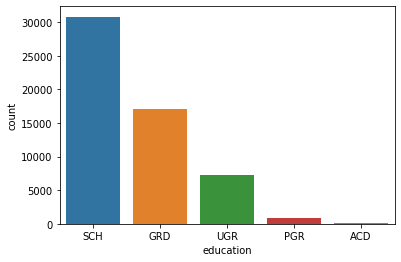

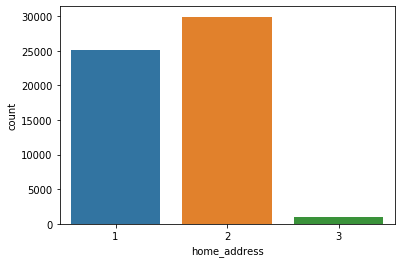

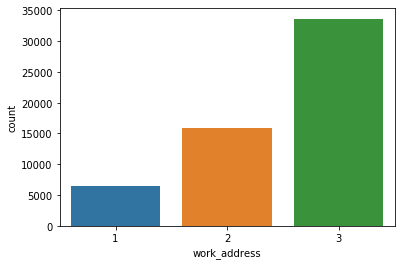

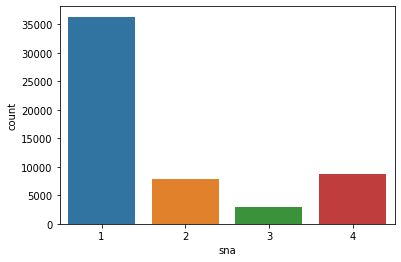

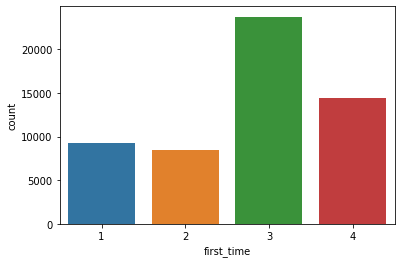

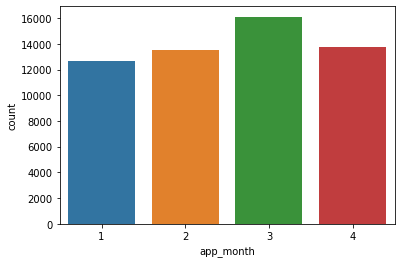

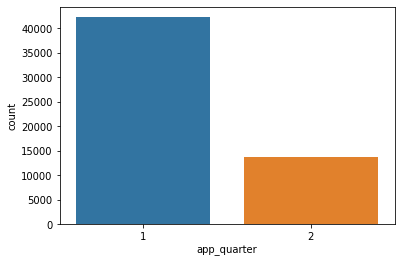

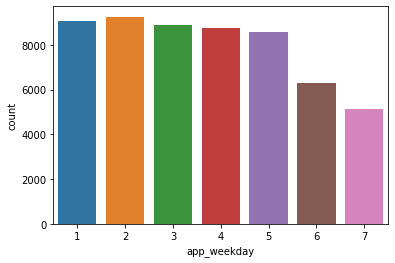

In [28]:
for i, col in enumerate(cat_cols):
    plt.figure(i)
    sns.countplot(x=col, data=data[data.is_test==0])

Исходя из графиков выше видимых проблем с данными нет. Далее произведем оценку значимости категориальных переменных.

## Оценка значимости категориальных переменных

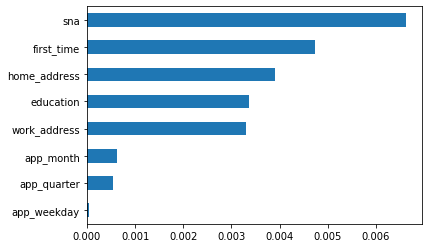

In [29]:
# Для оценки значимости с помощью LabelEncoder преобразуем категориальные переменные
label_encoder = LabelEncoder()

for column in cat_cols:
    data[column] = label_encoder.fit_transform(data[column])
    

imp_cat = Series(mutual_info_classif(data[data['is_test'] == 0][cat_cols], data[data['is_test'] == 0]['default'],
                                     discrete_features =True), index = cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Согласно графику выше самый значимый категориальный параметр - sna. Менее значимый - app_weekday

## Сбалансированность выборки

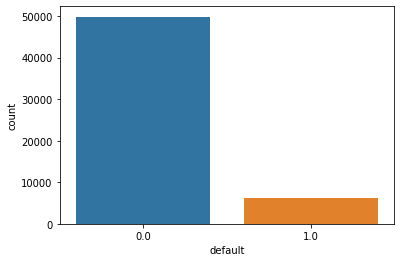

In [30]:
# Снова построим график распределения параметра default для тренировочной выборки
sns.countplot(data[data.is_test==0]['default'])

Согласно графику выше выборка не сбалансирована и этом может повлиять на обучаемость модели. Увеличим кол-во примеров (oversampling) со сзначением default = 1

In [31]:
# вычислим соотношение на тренировочной выборке между значением 1 и 0 для default и возьмем целую часть от этого числа
diff_default=int(data[data.is_test==0].default.value_counts()[0]/data[data.is_test==0].default.value_counts()[1])
diff_default

8

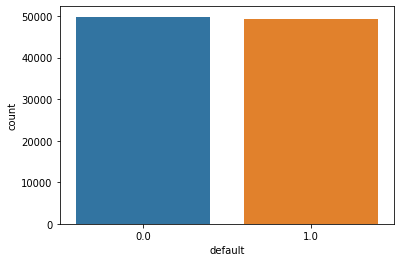

In [32]:
# увеличим кол-во значение с default=1 согласно получившемуся соотношению
def_1 = data[data.default==1]
for i in range(7):
    data=pd.concat([data, def_1])

# Снова построим график распределения параметра default для тренировочной выборки и посмотрим на получившееся распределение
sns.countplot(data[data.is_test==0]['default'])

На данный момент тренировочная часть выборки более сбалансированна. 

## Преобразование признаков и разбиение выборки

In [33]:
data_train_2 = data.query('is_test == 0').drop(['is_test'], axis=1)
data_test_2 = data.query('is_test == 1').drop(['is_test'], axis=1)

    
X_train_cat = OneHotEncoder(sparse = False).fit_transform(data_train_2[cat_cols].values)
X_test_cat = OneHotEncoder(sparse = False).fit_transform(data_test_2[cat_cols].values)

X_train_num = StandardScaler().fit_transform(data_train_2[num_cols].values)
X_test_num = StandardScaler().fit_transform(data_test_2[num_cols].values)

In [34]:
X_TR = np.hstack([X_train_num, data_train_2[bin_cols].values, X_train_cat])
Y_TR = data_train_2['default'].values

X_TE = np.hstack([X_test_num, data_test_2[bin_cols].values, X_test_cat])

In [35]:
X_train, X_valid, y_train, y_valid = train_test_split(X_TR, Y_TR, test_size=0.20, random_state=42)

# Обучение

In [36]:
model=LogisticRegression(random_state=RANDOM_SEED)
model.fit(X_train, y_train)


LogisticRegression(random_state=42)

In [37]:
probs = model.predict_proba(X_valid)
probs = probs[:,1]
y_pred = model.predict(X_valid)
# получим значение roc_auc
roc_auc = roc_auc_score(y_valid, probs)


In [38]:
roc_auc

0.7123111192664767

Для оценки получившихся данных построим roc-кривую

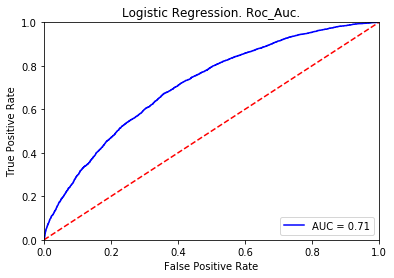

In [39]:
dispaly_roc_curve(y_valid, probs)

Если взять за основу следующую шкалу:<br>
AUC между 0.8 и 1 - модель рабоатет отлично<br>
AUC между 0.6 и 0.8 - модель работае хорошо<br>
AUC между 0.5 и 0.6 - модель рабоатет удовлетворительно<br>
AUC = меньше 0.5 - модель не работает<br>
То можно сделать вывод, что наша модель работает хорошо. <br>

Построим confusion-matrix для доп. оценки нашей модели. 

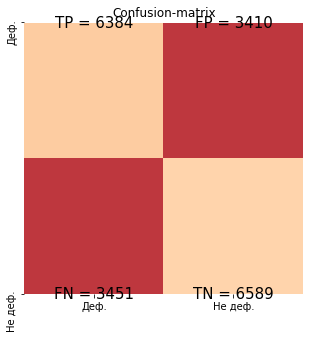

['TP = 6384', 'FP = 3410', 'FN = 3451', 'TN = 6589']
Pos: 6384 from 9835 (0.6491103202846975)
Neg: 6589 from 9999 (0.658965896589659)


In [40]:
display_confusion_matrix(y_valid, y_pred)

In [41]:
display_metrics(y_valid, y_pred)

accuracy = 0.654078854492286
precision = 0.6518276495813764
recall = 0.6491103202846975
F1-score = 0.6504661470273575


Модель верно предсказала 65% положительных результатов (6384 из 9835)<br>
И 66% негативных результатов (6589 из 9999)
<br>
Исходя из этих данных можно сделать вывод, что модель уже неплохо работает, но стоит попробовать улучшить ее работу с помощью регуляризации. 

In [42]:
params = {"C":np.logspace(0, 4, 10), "penalty":["l1","l2"]}
model = LogisticRegression(random_state=RANDOM_SEED, solver='liblinear')
clf = GridSearchCV(model, params, cv=15, verbose=0)
best_model = clf.fit(X_train, y_train)

print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 1.0


In [43]:
best_model.fit(X_train, y_train)

GridSearchCV(cv=15,
             estimator=LogisticRegression(random_state=42, solver='liblinear'),
             param_grid={'C': array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2']})

In [44]:
probs = best_model.predict_proba(X_valid)
probs = probs[:,1]
y_pred = best_model.predict(X_valid)
# получим значение roc_auc
roc_auc = roc_auc_score(y_valid, probs)


In [45]:
roc_auc

0.7123089634840455

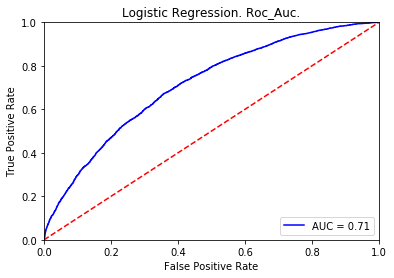

In [46]:
dispaly_roc_curve(y_valid, probs)

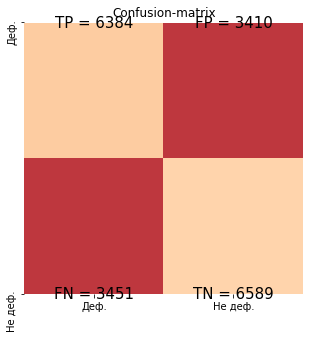

['TP = 6384', 'FP = 3410', 'FN = 3451', 'TN = 6589']
Pos: 6384 from 9835 (0.6491103202846975)
Neg: 6589 from 9999 (0.658965896589659)


In [47]:
display_confusion_matrix(y_valid, y_pred)

In [48]:
display_metrics(y_valid, y_pred)

accuracy = 0.654078854492286
precision = 0.6518276495813764
recall = 0.6491103202846975
F1-score = 0.6504661470273575


Исходя из полученных результатов регуляризация не повлияла на предсказание модели.  